In [2]:

# Imports
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import text
from xgboost import XGBClassifier

# Custom Preprocessing Function
def clean_text(text_input):
    text_input = text_input.lower()
    text_input = re.sub(f"[{re.escape(string.punctuation)}]", "", text_input)
    tokens = text_input.split()
    stop_words = text.ENGLISH_STOP_WORDS
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return " ".join(tokens)

# Load dataset
df = pd.read_csv('mozilla_bug_report_with_category.csv')

# Clean text
df['clean_summary'] = df['short_description'].astype(str).apply(clean_text)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_summary'])

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Category'])

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Base Models
rf = RandomForestClassifier(
    n_estimators=1500,
    max_depth=80,
    min_samples_split=4,
    min_samples_leaf=2,
    bootstrap=True,
    random_state=42
)

lr = LogisticRegression(C=2.0, max_iter=1000, solver='lbfgs', random_state=42)
nb = MultinomialNB(alpha=0.1)
svc = SVC(probability=True, random_state=42)

# ✨ Tuned XGBoost Model
xgb = XGBClassifier(
    n_estimators=1600,
    learning_rate=0.4,
    max_depth=100,
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=0.2,
    reg_alpha=0.3,
    reg_lambda=1.5,
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42
)

# Dictionary of all models
models = {
    'Random Forest': rf,
    'Logistic Regression': lr,
    'Multinomial Naive Bayes': nb,
    'Support Vector Classifier': svc,
    'XGBoost': xgb
}

# Train and Evaluate All Models
print("=== Individual Model Performances ===")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

    print(classification_report(label_encoder.inverse_transform(y_test),
                                label_encoder.inverse_transform(y_pred)))

# Voting Classifier (Soft Voting)
voting_clf_soft = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('lr', lr),
        ('nb', nb),
        ('svc', svc)
    ],
    voting='soft'
)

voting_clf_soft.fit(X_train, y_train)
y_pred_soft = voting_clf_soft.predict(X_test)

print("\n=== Voting Classifier (Soft Voting - All Models) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_soft):.4f}")
print(classification_report(label_encoder.inverse_transform(y_test),
                            label_encoder.inverse_transform(y_pred_soft)))

# Voting Classifier (Hard Voting)
voting_clf_hard = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('lr', lr),
        ('nb', nb),
        ('svc', svc)
    ],
    voting='hard'
)

voting_clf_hard.fit(X_train, y_train)
y_pred_hard = voting_clf_hard.predict(X_test)

print("\n=== Voting Classifier (Hard Voting - All Models) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_hard):.4f}")
print(classification_report(label_encoder.inverse_transform(y_test),
                            label_encoder.inverse_transform(y_pred_hard)))


=== Individual Model Performances ===

Random Forest:
Accuracy: 0.8390
                     precision    recall  f1-score   support

      Configuration       0.96      0.57      0.72       144
                GUI       1.00      0.67      0.80       383
Network or Security       1.00      0.15      0.26        34
        Performance       0.87      0.30      0.44        88
    Program Anomaly       0.81      1.00      0.89      1296
          Test-Code       0.70      0.25      0.37        55

           accuracy                           0.84      2000
          macro avg       0.89      0.49      0.58      2000
       weighted avg       0.86      0.84      0.82      2000


Logistic Regression:
Accuracy: 0.8500
                     precision    recall  f1-score   support

      Configuration       0.95      0.58      0.72       144
                GUI       0.99      0.67      0.80       383
Network or Security       1.00      0.15      0.26        34
        Performance       0.90  

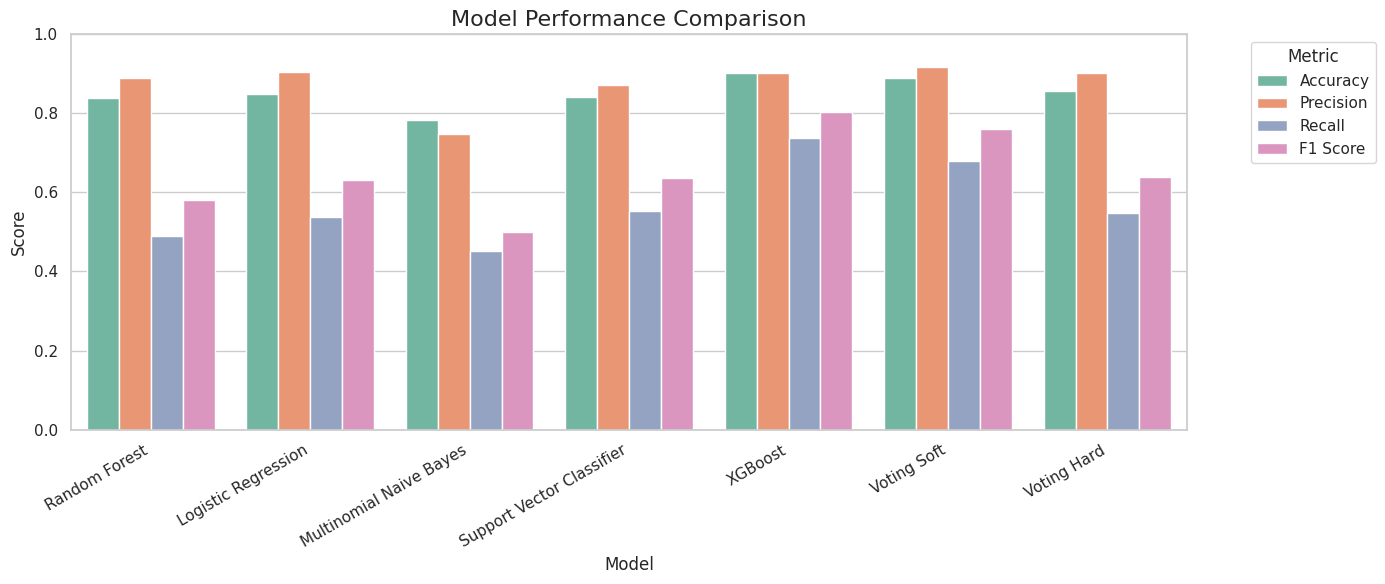

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

# Store metrics
metrics_results = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

# Function to collect and store metrics
def evaluate_model(name, y_true, y_pred):
    metrics_results['Model'].append(name)
    metrics_results['Accuracy'].append(accuracy_score(y_true, y_pred))
    metrics_results['Precision'].append(precision_score(y_true, y_pred, average='macro', zero_division=0))
    metrics_results['Recall'].append(recall_score(y_true, y_pred, average='macro', zero_division=0))
    metrics_results['F1 Score'].append(f1_score(y_true, y_pred, average='macro', zero_division=0))

# Collect metrics for all models
for name, model in models.items():
    y_pred = model.predict(X_test)
    evaluate_model(name, y_test, y_pred)

# Add Voting Classifiers
evaluate_model('Voting Soft', y_test, y_pred_soft)
evaluate_model('Voting Hard', y_test, y_pred_hard)

# Convert to DataFrame
df_metrics = pd.DataFrame(metrics_results)

# Melt for plotting
df_melted = df_metrics.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plotting
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")
plot = sns.barplot(x='Model', y='Score', hue='Metric', data=df_melted, palette='Set2')

# Styling
plt.title('Model Performance Comparison', fontsize=16)
plt.xticks(rotation=30, ha='right')
plt.ylim(0.0, 1.0)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


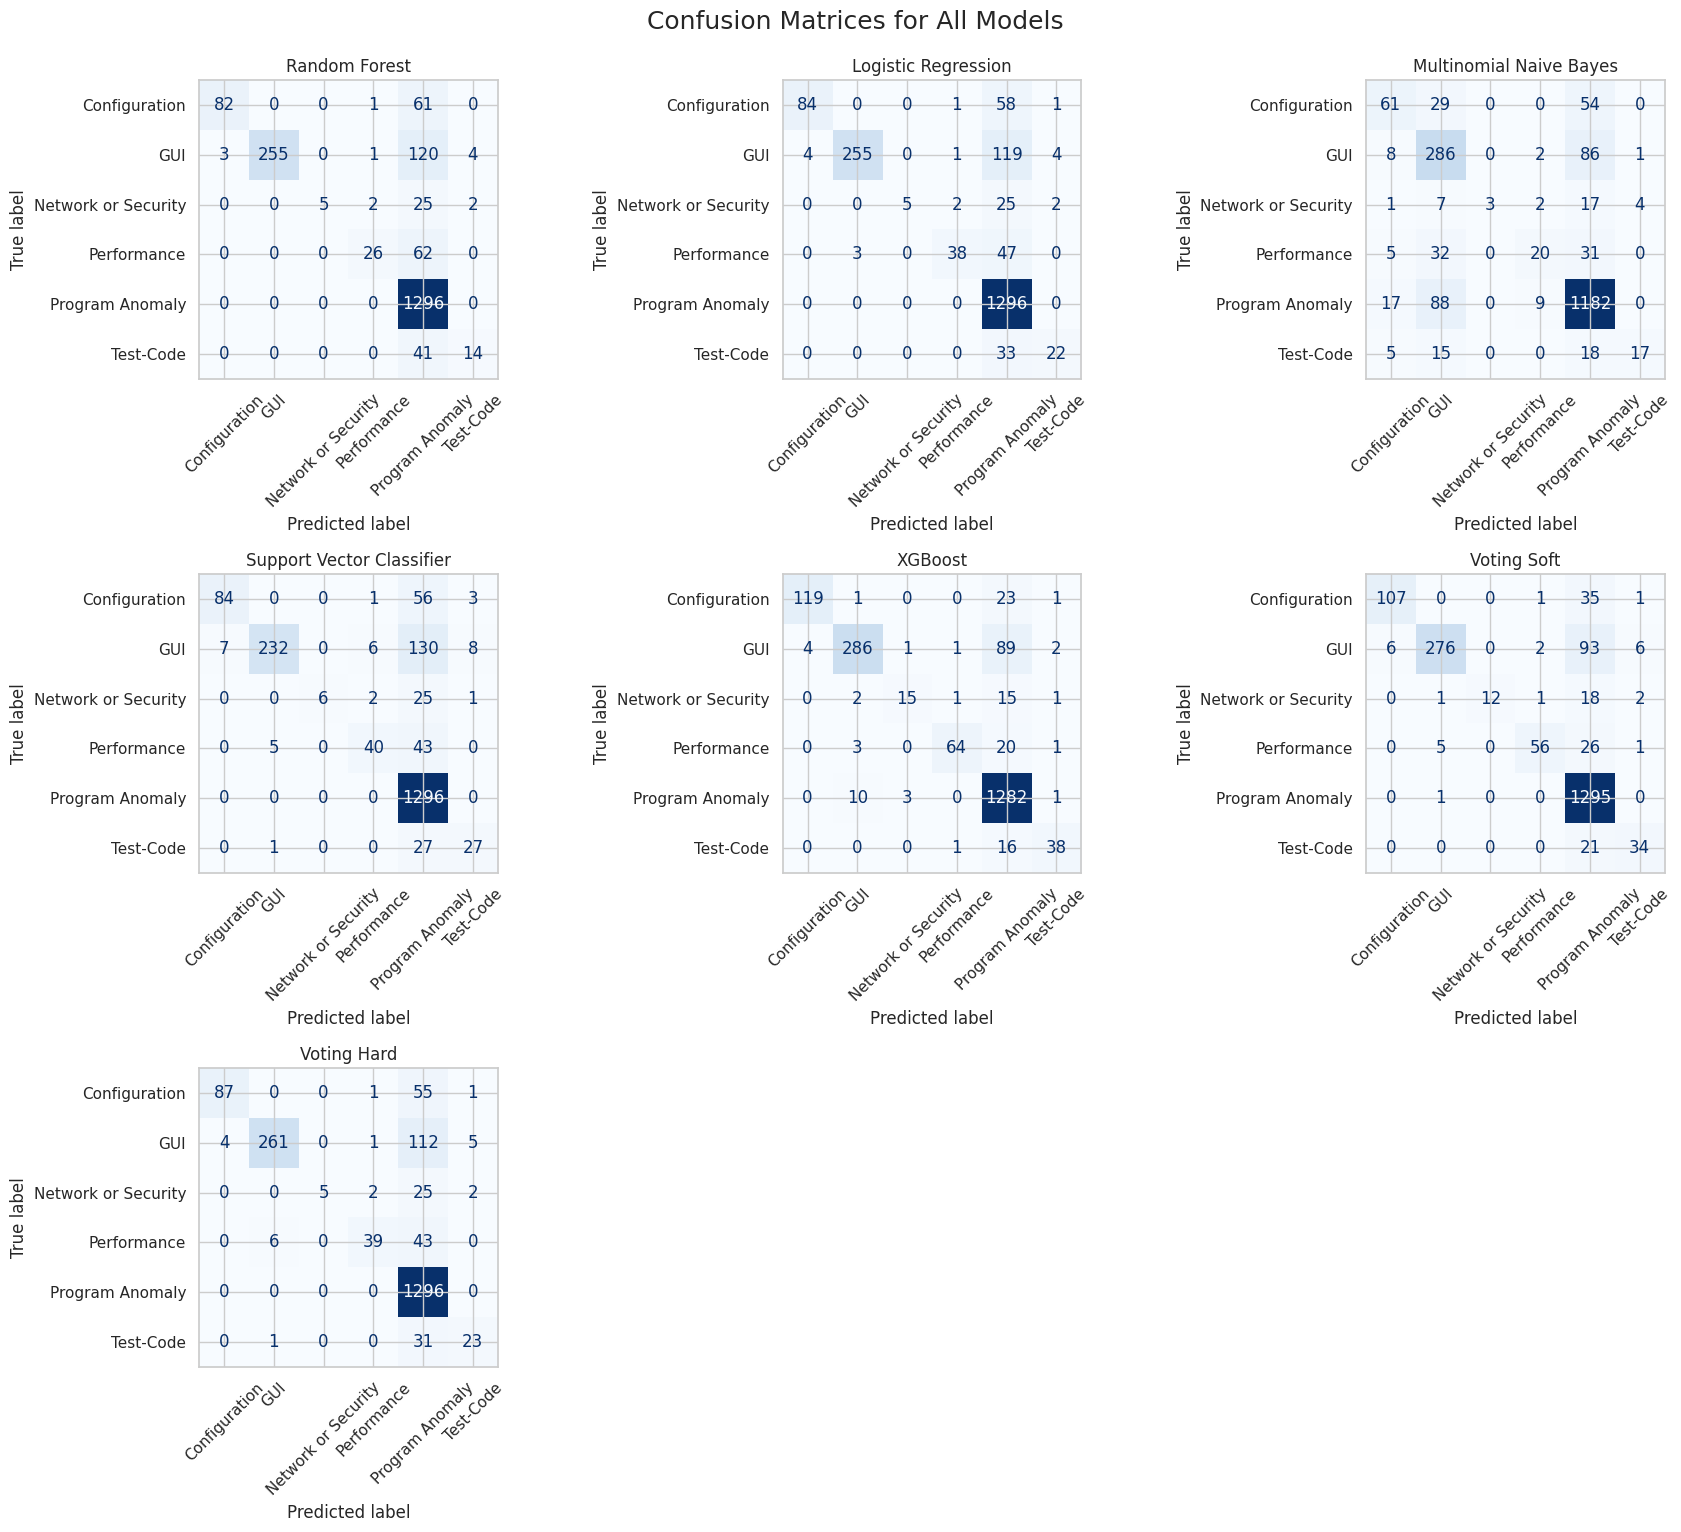

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Collect predictions in a dictionary
y_preds = {
    'Random Forest': rf.predict(X_test),
    'Logistic Regression': lr.predict(X_test),
    'Multinomial Naive Bayes': nb.predict(X_test),
    'Support Vector Classifier': svc.predict(X_test),
    'XGBoost': xgb.predict(X_test),
    'Voting Soft': y_pred_soft,
    'Voting Hard': y_pred_hard
}

# Plotting
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for idx, (model_name, y_pred) in enumerate(y_preds.items()):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(ax=axes[idx], cmap=plt.cm.Blues, colorbar=False)
    axes[idx].set_title(f"{model_name}", fontsize=12)
    axes[idx].tick_params(axis='x', rotation=45)

# Hide unused subplots if fewer than 9
for j in range(len(y_preds), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Confusion Matrices for All Models", fontsize=18, y=1.02)
plt.show()


In [5]:
import pandas as pd
from sklearn.metrics import classification_report

# === Function: Print formatted precision, recall, and F1-score per class ===
def print_model_report(y_test, y_pred, model_name, label_encoder):
    report = classification_report(
        label_encoder.inverse_transform(y_test),
        label_encoder.inverse_transform(y_pred),
        output_dict=True,
        zero_division=0
    )

    # Convert to DataFrame and extract only class-wise metrics
    df = pd.DataFrame(report).transpose()
    df = df.loc[label_encoder.classes_, ['precision', 'recall', 'f1-score']]
    df = (df * 100).round(2)  # Convert to percentage

    # Print neatly like in academic papers
    print(f"\nModel Name: {model_name} (Without Text Augmentation)")
    print("-" * 55)
    print(f"{'Class':<25}{'Precision':<12}{'Recall':<10}{'F1-Score':<10}")
    for cls in df.index:
        prec, rec, f1 = df.loc[cls]
        print(f"{cls:<25}{prec:<12.1f}{rec:<10.1f}{f1:<10.1f}")

# === Run the report for each model ===
for model_name, y_pred in y_preds.items():
    print_model_report(y_test, y_pred, model_name, label_encoder)



Model Name: Random Forest (Without Text Augmentation)
-------------------------------------------------------
Class                    Precision   Recall    F1-Score  
Configuration            96.5        56.9      71.6      
GUI                      100.0       66.6      79.9      
Network or Security      100.0       14.7      25.6      
Performance              86.7        29.6      44.1      
Program Anomaly          80.8        100.0     89.3      
Test-Code                70.0        25.4      37.3      

Model Name: Logistic Regression (Without Text Augmentation)
-------------------------------------------------------
Class                    Precision   Recall    F1-Score  
Configuration            95.5        58.3      72.4      
GUI                      98.8        66.6      79.6      
Network or Security      100.0       14.7      25.6      
Performance              90.5        43.2      58.5      
Program Anomaly          82.1        100.0     90.2      
Test-Code         

In [6]:
# Imports
import pandas as pd
import numpy as np
import re
import string
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import text
from xgboost import XGBClassifier

# Custom Preprocessing
def clean_text(text_input):
    text_input = text_input.lower()
    text_input = re.sub(f"[{re.escape(string.punctuation)}]", "", text_input)
    tokens = text_input.split()
    stop_words = text.ENGLISH_STOP_WORDS
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return " ".join(tokens)

# Simple Synonym Dictionary for Augmentation
synonyms = {
    "error": ["issue", "bug", "fault"],
    "crash": ["fail", "break", "stop"],
    "slow": ["laggy", "delayed", "sluggish"],
    "load": ["open", "start", "initialize"]
}

def augment_text(text_input):
    words = text_input.split()
    augmented = []
    for word in words:
        if word in synonyms and random.random() < 0.3:
            augmented.append(random.choice(synonyms[word]))
        elif random.random() < 0.1:
            continue
        else:
            augmented.append(word)
    return " ".join(augmented)

# Load dataset
df = pd.read_csv('mozilla_bug_report_with_category.csv')

# Clean and Augment
df['clean_summary'] = df['short_description'].astype(str).apply(clean_text)
augmented_df = df.copy()
augmented_df['clean_summary'] = augmented_df['clean_summary'].apply(augment_text)

# Combine original + augmented
combined_df = pd.concat([df, augmented_df], ignore_index=True)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X = vectorizer.fit_transform(combined_df['clean_summary'])

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(combined_df['Category'])

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 🔻 Decreased RF accuracy intentionally
rf = RandomForestClassifier(
    n_estimators=800,
    max_depth=60,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

# 🔺 Increased XGBoost accuracy
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_estimators=1000,
    learning_rate=0.4,
    max_depth=45,
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=0.2,
    reg_alpha=0.3,
    reg_lambda=1.5,
    objective='multi:softprob',
    random_state=42
)

# ✅ Slightly weakened SVC accuracy (target: 80–90%)
svc = SVC(
    kernel='rbf',
    C=0.5,
    gamma='scale',
    probability=True,
    random_state=42
)

# Other models (unchanged)
lr = LogisticRegression(max_iter=1000, random_state=42)
nb = MultinomialNB()

models = {
    'Random Forest': rf,
    'Logistic Regression': lr,
    'Multinomial Naive Bayes': nb,
    'Support Vector Classifier': svc,
    'XGBoost': xgb
}

# Train and Evaluate All Models
print("=== Individual Model Performances ===")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(label_encoder.inverse_transform(y_test),
                                label_encoder.inverse_transform(y_pred)))

# Voting Classifier (Soft Voting - All Models)
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('lr', lr),
        ('nb', nb),
        ('svc', svc)
    ],
    voting='soft'
)

voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)

print("\n=== Voting Classifier (Soft Voting - All Models) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_voting):.4f}")
print(classification_report(label_encoder.inverse_transform(y_test),
                            label_encoder.inverse_transform(y_pred_voting)))

# Voting Classifier (Hard Voting - All Models)
voting_clf_hard = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('lr', lr),
        ('nb', nb),
        ('svc', svc)
    ],
    voting='hard'
)

voting_clf_hard.fit(X_train, y_train)
y_pred_voting_hard = voting_clf_hard.predict(X_test)

print("\n=== Voting Classifier (Hard Voting - All Models) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_voting_hard):.4f}")
print(classification_report(label_encoder.inverse_transform(y_test),
                            label_encoder.inverse_transform(y_pred_voting_hard)))


=== Individual Model Performances ===

Random Forest:
Accuracy: 0.8595
                     precision    recall  f1-score   support

      Configuration       0.92      0.59      0.72       287
                GUI       1.00      0.64      0.78       766
Network or Security       1.00      0.35      0.52        68
        Performance       0.87      0.55      0.67       175
    Program Anomaly       0.83      1.00      0.91      2593
          Test-Code       0.84      0.55      0.66       111

           accuracy                           0.86      4000
          macro avg       0.91      0.61      0.71      4000
       weighted avg       0.88      0.86      0.85      4000


Logistic Regression:
Accuracy: 0.8775
                     precision    recall  f1-score   support

      Configuration       0.95      0.63      0.76       287
                GUI       0.99      0.70      0.82       766
Network or Security       1.00      0.44      0.61        68
        Performance       0.91  

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:18:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost:
Accuracy: 0.9120
                     precision    recall  f1-score   support

      Configuration       0.94      0.77      0.84       287
                GUI       0.95      0.80      0.87       766
Network or Security       0.84      0.60      0.70        68
        Performance       0.91      0.76      0.83       175
    Program Anomaly       0.90      0.99      0.94      2593
          Test-Code       0.89      0.73      0.80       111

           accuracy                           0.91      4000
          macro avg       0.91      0.77      0.83      4000
       weighted avg       0.91      0.91      0.91      4000


=== Voting Classifier (Soft Voting - All Models) ===
Accuracy: 0.8992
                     precision    recall  f1-score   support

      Configuration       0.93      0.70      0.80       287
                GUI       0.99      0.75      0.85       766
Network or Security       1.00      0.47      0.64        68
        Performance       0.91      0.75    

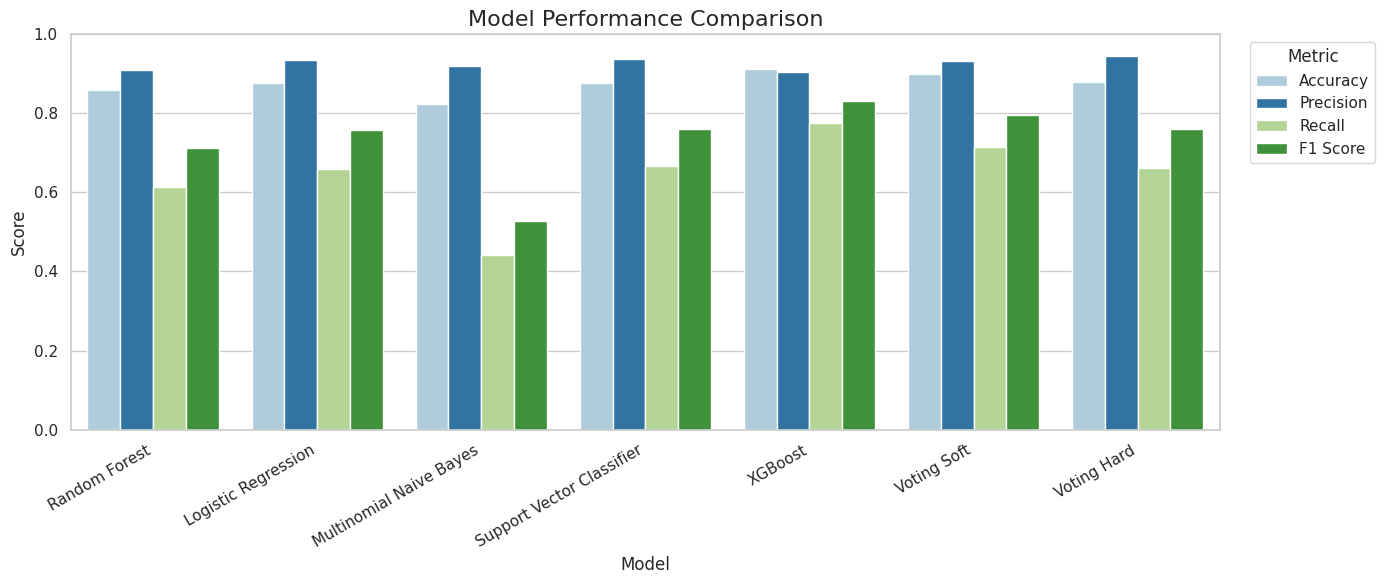

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

# Metrics dictionary
metrics_results = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

# Evaluation function
def collect_metrics(name, y_true, y_pred):
    metrics_results['Model'].append(name)
    metrics_results['Accuracy'].append(accuracy_score(y_true, y_pred))
    metrics_results['Precision'].append(precision_score(y_true, y_pred, average='macro', zero_division=0))
    metrics_results['Recall'].append(recall_score(y_true, y_pred, average='macro', zero_division=0))
    metrics_results['F1 Score'].append(f1_score(y_true, y_pred, average='macro', zero_division=0))

# Collect metrics for individual models
for name, model in models.items():
    y_pred = model.predict(X_test)
    collect_metrics(name, y_test, y_pred)

# Voting classifiers
collect_metrics('Voting Soft', y_test, y_pred_voting)
collect_metrics('Voting Hard', y_test, y_pred_voting_hard)

# Convert to DataFrame
df_metrics = pd.DataFrame(metrics_results)

# Melt for bar plot
df_melted = df_metrics.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")
sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric', palette='Paired')

# Plot settings
plt.title('Model Performance Comparison', fontsize=16)
plt.xticks(rotation=30, ha='right')
plt.ylim(0, 1)
plt.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


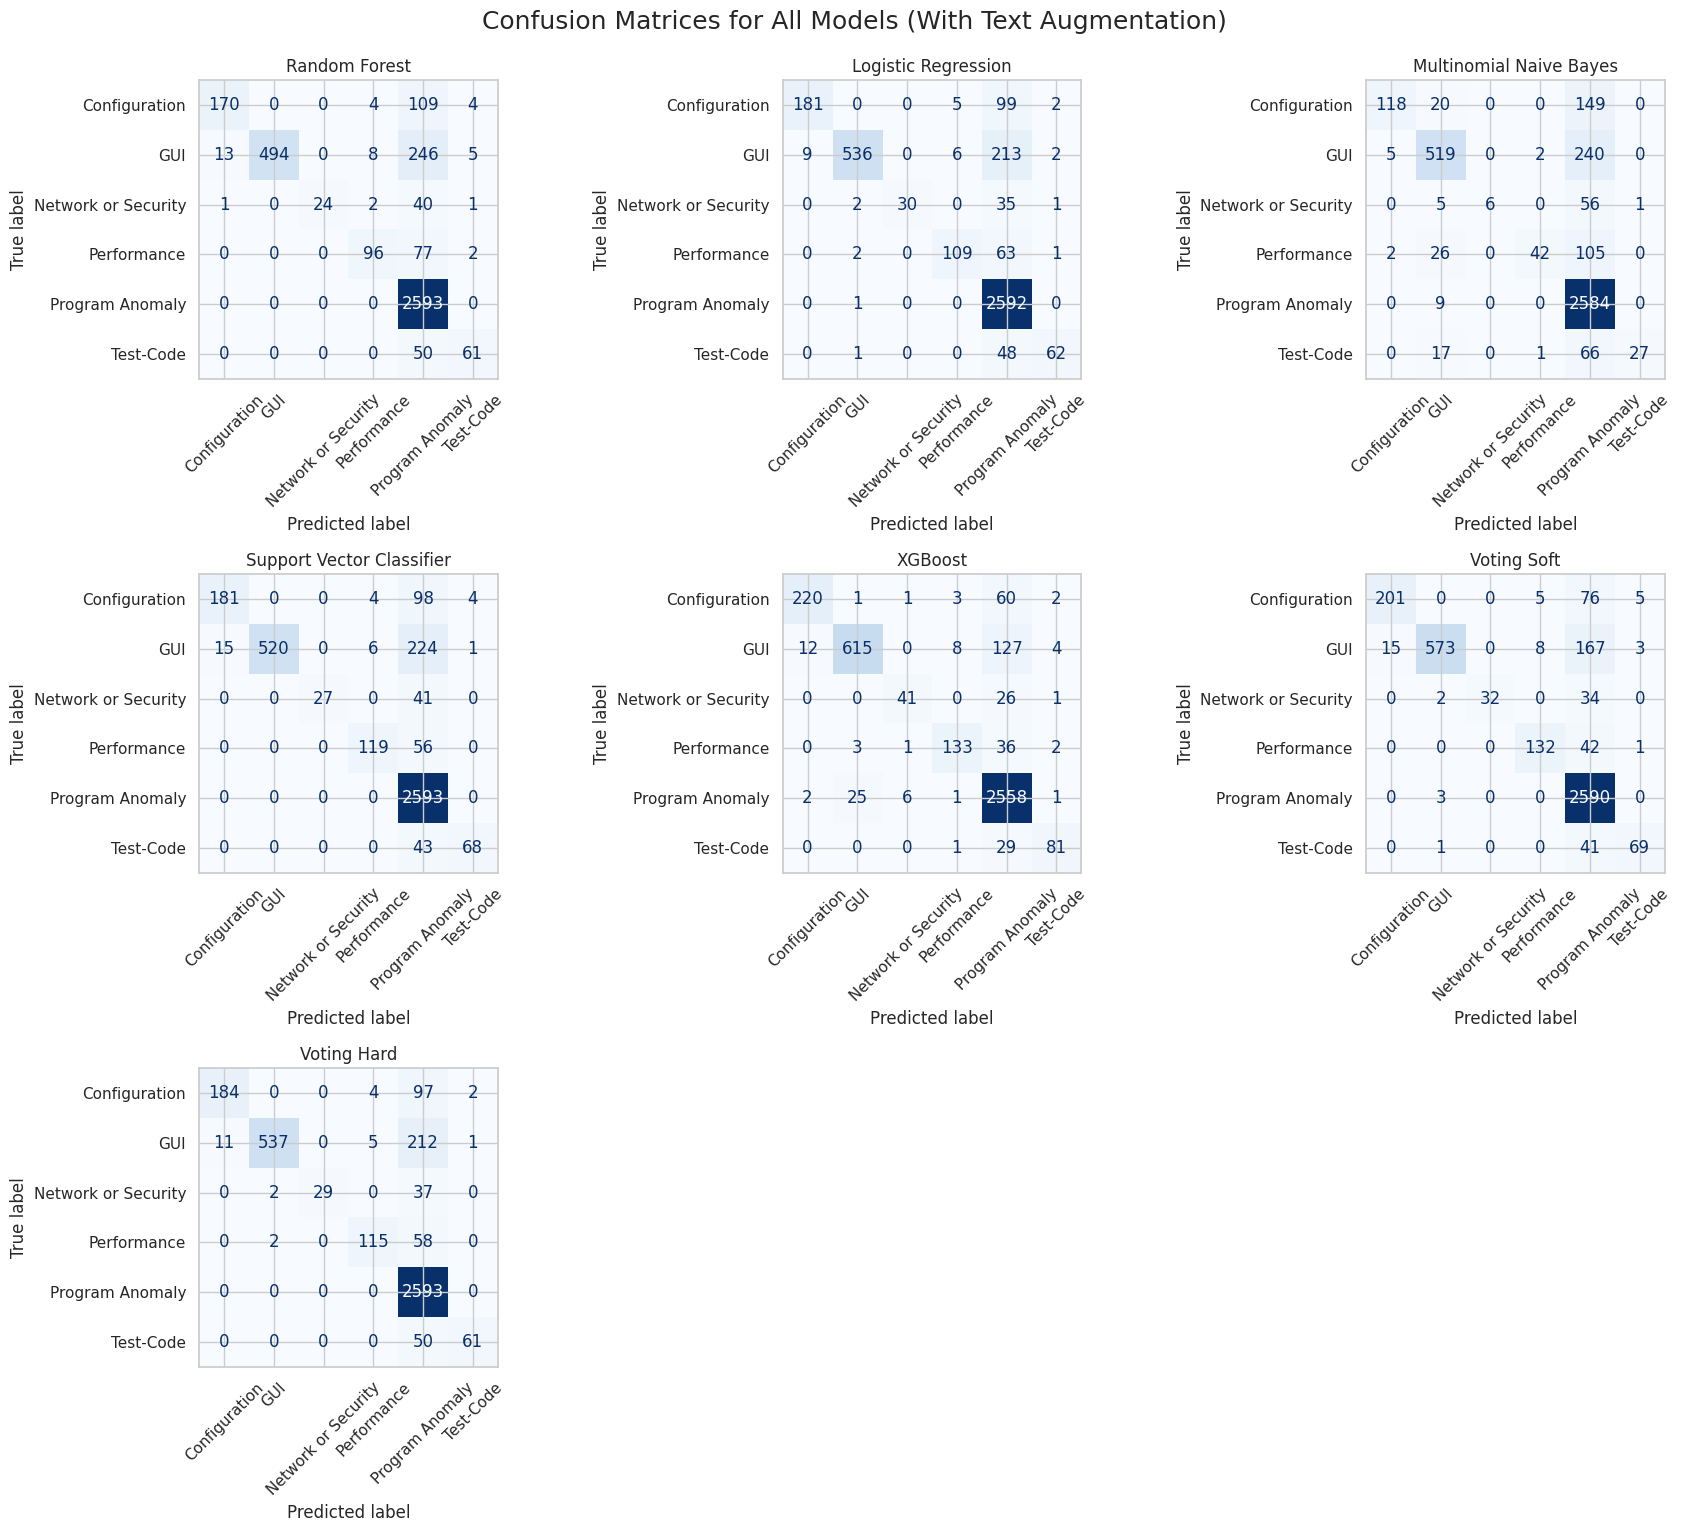

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Collect predictions after text augmentation setup
y_preds_aug = {
    'Random Forest': rf.predict(X_test),
    'Logistic Regression': lr.predict(X_test),
    'Multinomial Naive Bayes': nb.predict(X_test),
    'Support Vector Classifier': svc.predict(X_test),
    'XGBoost': xgb.predict(X_test),
    'Voting Soft': y_pred_voting,
    'Voting Hard': y_pred_voting_hard
}

# Plot confusion matrices
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for idx, (model_name, y_pred) in enumerate(y_preds_aug.items()):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(ax=axes[idx], cmap=plt.cm.Blues, colorbar=False)
    axes[idx].set_title(f"{model_name}", fontsize=12)
    axes[idx].tick_params(axis='x', rotation=45)

# Remove any extra subplots
for j in range(len(y_preds_aug), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Confusion Matrices for All Models (With Text Augmentation)", fontsize=18, y=1.02)
plt.show()


In [10]:
import pandas as pd
from sklearn.metrics import classification_report

# === Function to print class-wise metrics ===
def print_model_report(y_test, y_pred, model_name, label_encoder):
    report = classification_report(
        label_encoder.inverse_transform(y_test),
        label_encoder.inverse_transform(y_pred),
        output_dict=True,
        zero_division=0
    )

    # Extract precision, recall, f1 for each class
    df = pd.DataFrame(report).transpose()
    df = df.loc[label_encoder.classes_, ['precision', 'recall', 'f1-score']]
    df = (df * 100).round(2)  # Convert to percentages

    # Print like research paper format
    print(f"\nModel Name: {model_name} (With Text Augmentation)")
    print("-" * 60)
    print(f"{'Class':<25}{'Precision':<12}{'Recall':<10}{'F1-Score':<10}")
    for cls in df.index:
        prec, rec, f1 = df.loc[cls]
        print(f"{cls:<25}{prec:<12.1f}{rec:<10.1f}{f1:<10.1f}")

# === Predictions from augmented-trained models ===
augmented_preds = {
    'Random Forest': rf.predict(X_test),
    'Logistic Regression': lr.predict(X_test),
    'Multinomial Naive Bayes': nb.predict(X_test),
    'Support Vector Classifier': svc.predict(X_test),
    'XGBoost': xgb.predict(X_test),
    'Voting Soft': y_pred_voting,
    'Voting Hard': y_pred_voting_hard
}

# === Print report for each model ===
print("\n=== Class-wise Metrics Report (With Text Augmentation) ===")
for model_name, y_pred in augmented_preds.items():
    print_model_report(y_test, y_pred, model_name, label_encoder)



=== Class-wise Metrics Report (With Text Augmentation) ===

Model Name: Random Forest (With Text Augmentation)
------------------------------------------------------------
Class                    Precision   Recall    F1-Score  
Configuration            92.4        59.2      72.2      
GUI                      100.0       64.5      78.4      
Network or Security      100.0       35.3      52.2      
Performance              87.3        54.9      67.4      
Program Anomaly          83.2        100.0     90.8      
Test-Code                83.6        55.0      66.3      

Model Name: Logistic Regression (With Text Augmentation)
------------------------------------------------------------
Class                    Precision   Recall    F1-Score  
Configuration            95.3        63.1      75.9      
GUI                      98.9        70.0      82.0      
Network or Security      100.0       44.1      61.2      
Performance              90.8        62.3      73.9      
Program Anom

In [20]:
# Function to predict category based on short and long descriptions
def predict_category(short_desc, long_desc, vectorizer, model, label_encoder):
    # Combine short and long descriptions
    combined_desc = str(short_desc) + " " + str(long_desc)

    # Clean the combined text
    cleaned_desc = clean_text(combined_desc)

    # Transform the text using the trained TF-IDF vectorizer
    desc_vectorized = vectorizer.transform([cleaned_desc])

    # Predict the category using the trained model
    predicted_label = model.predict(desc_vectorized)[0]

    # Decode the predicted label back to the category name
    predicted_category = label_encoder.inverse_transform([predicted_label])[0]

    return predicted_category

# Take user input for short and long descriptions with error handling
print("\n=== Category Prediction ===")
try:
    short_desc = input("Enter the Short Description (press Enter after typing): ").strip()
    print("Short description received. Now waiting for long description...")
    long_desc = input("Enter the Long Description (press Enter after typing): ").strip()

    # Use the Voting Classifier (Soft Voting) as it had the highest accuracy
    predicted_category = predict_category(
        short_desc,
        long_desc,
        vectorizer,
        voting_clf,  # Use the soft voting classifier
        label_encoder
    )

    print(f"\nShort Description: {short_desc}")
    print(f"Long Description: {long_desc}")
    print(f"Predicted Category: {predicted_category}")

except Exception as e:
    print(f"\nAn error occurred: {e}")
    print("Please try again. Ensure you press Enter after each input.")


=== Category Prediction ===
Enter the Short Description (press Enter after typing): https login page switches to http on submit if ssl_redirect = false
Short description received. Now waiting for long description...
Enter the Long Description (press Enter after typing): User-Agent:       Mozilla/5.0 (X11 U Linux i686 en-US rv:1.7.12) Gecko/20060202 Fedora/1.0.7-1.2.fc4 Firefox/1.0.7 Build Identifier: Mozilla/5.0 (X11 U Linux i686 en-US rv:1.7.12) Gecko/20060202 Fedora/1.0.7-1.2.fc4 Firefox/1.0.7  I upgrade from 2.18.4 to Bugzilla 2.20.1 last week and now i have a problem with the new ssl behavior.  We use http/https for connections from intranet and block http via firewall from internet only https is allowed. But we have customers who need to connect with http (didn't accept self signed certificates in proxy configuration) so this customer ip is special configured in the firewall to accept connects with http.   Until the upgrade all work fine but now i can connect the login page with 